# Regression: Bike Sharing

Dataset: Seoul Bike Sharing Demand [Dataset]. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [ ]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [ ]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


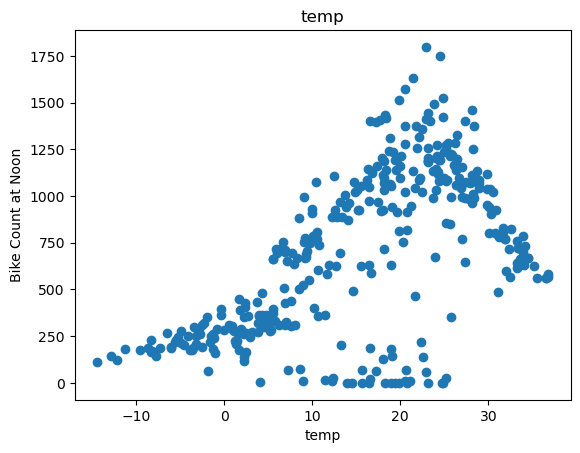

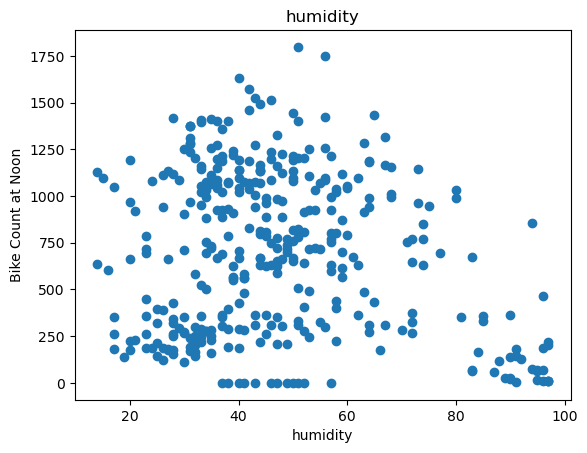

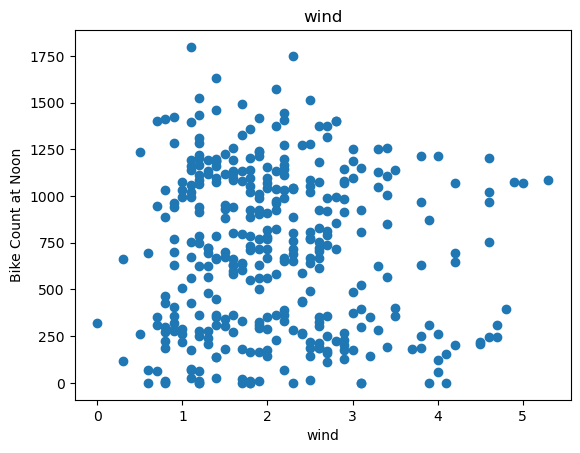

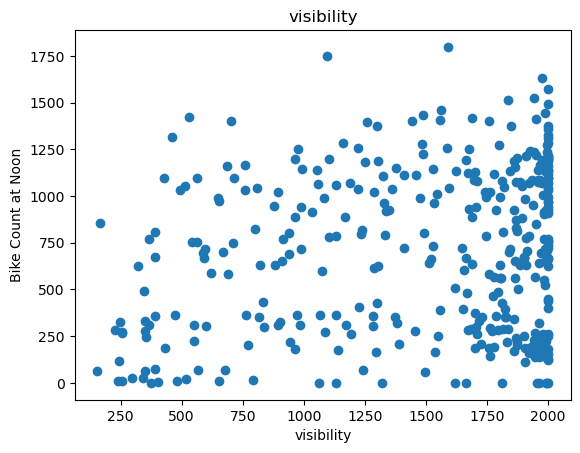

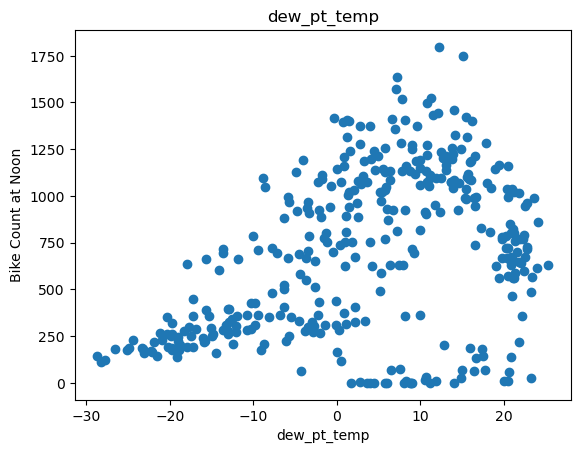

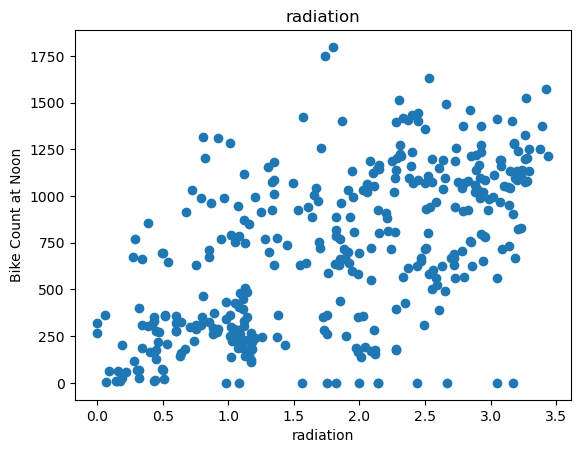

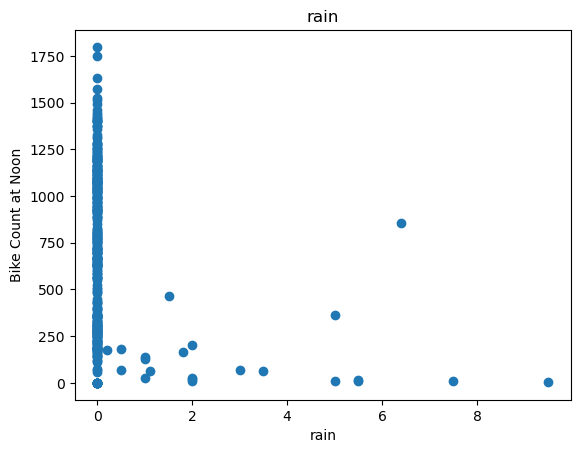

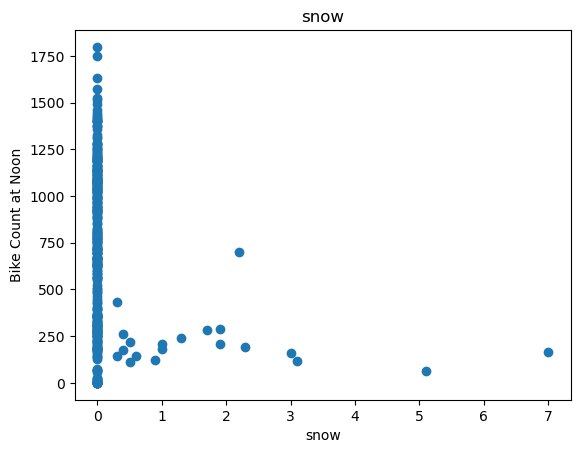

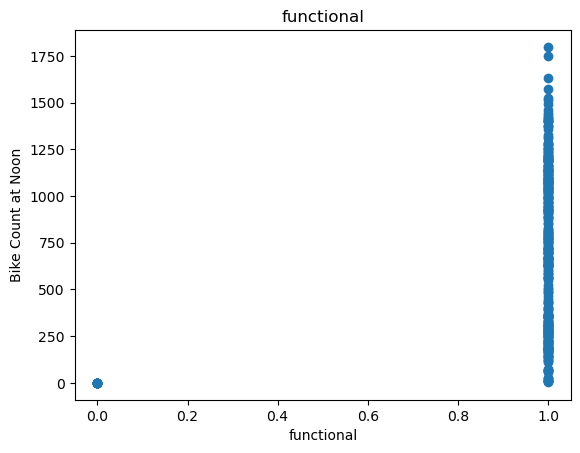

In [ ]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel("Bike Count at Noon")
    plt.show()

In [ ]:
df = df.drop(["wind", "visibility", "functional"], axis=1)

In [ ]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


## Train, validation, test datasets

In [ ]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

C:\Users\emily\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        x = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_labels) == 1:
            x = dataframe[x_labels[0]].values.reshape(-1, 1)
        else: 
            x = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((x, y))

    return data, x, y

In [ ]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, x_valid_temp, y_valid_temp = get_xy(valid, "bike_count", x_labels=["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [ ]:
temp_reg.score(x_test_temp, y_test_temp)

0.3155834508837392

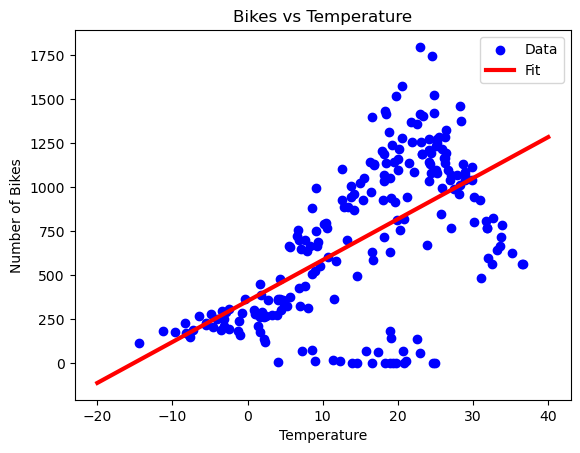

In [ ]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = np.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()

## Multiple Linear Regression

In [ ]:
_, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, x_valid_all, y_valid_all = get_xy(valid, "bike_count", x_labels=df.columns[1:])
_, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [ ]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [ ]:
all_reg.score(x_test_all, y_test_all)

0.50696837757098

## Regression with Neural Net

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [ ]:
temp_nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
history = temp_nn_model.fit(x_train_temp.reshape(-1), y_train_temp, verbose=0, epochs=1000, validation_data=(x_valid_temp, y_valid_temp))

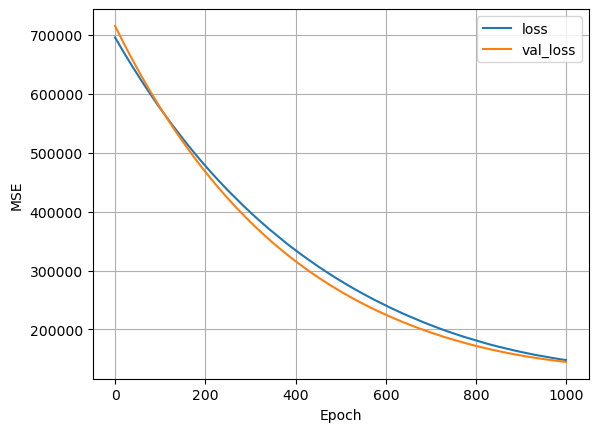

In [ ]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


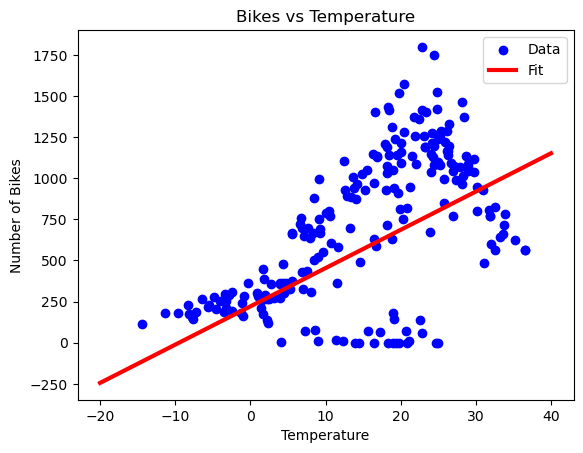

In [ ]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = np.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()

## Multiple Linear Regression with Neural Net

In [ ]:
all_normalizer = tf.keras.layers.Normalization(axis=None)
all_normalizer.adapt(x_train_all.reshape(-1))

In [ ]:
all_nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(6,)),
    all_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [ ]:
history = all_nn_model.fit(x_train_all, y_train_all, verbose=0, epochs=1000, validation_data=(x_valid_all, y_valid_all))

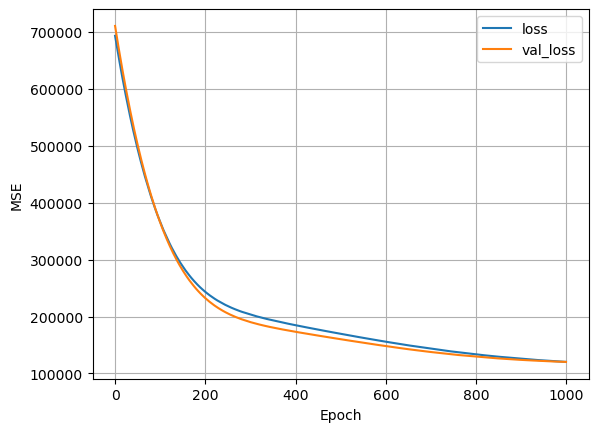

In [ ]:
plot_loss(history)

# Neural Net

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
history = nn_model.fit(
    x_train_temp, y_train_temp,
    validation_data=(x_valid_temp, y_valid_temp),
    epochs=100, verbose=0
)

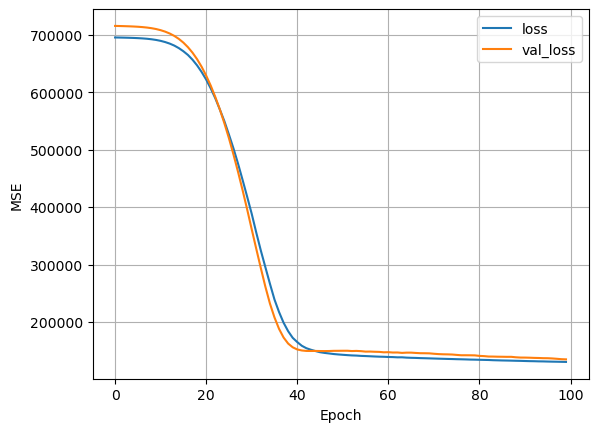

In [ ]:
plot_loss(history)

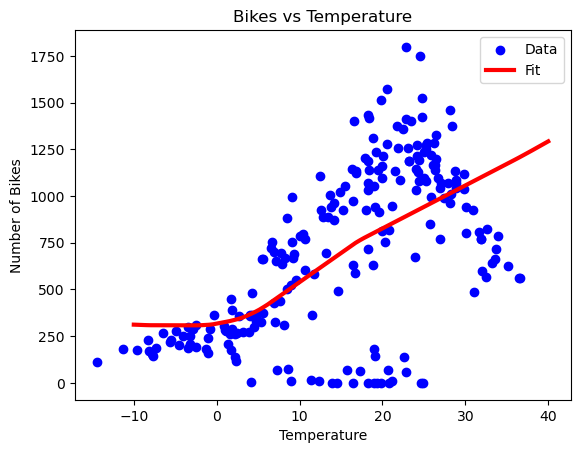

In [ ]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = np.linspace(-10, 40, 100)
y_pred = nn_model.predict(np.array(x).reshape(-1, 1), verbose=0)
plt.plot(x, y_pred, label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Number of Bikes")
plt.xlabel("Temperature")
plt.show()

In [ ]:
all_normalizer = tf.keras.layers.Normalization(axis=-1)
all_normalizer.adapt(x_train_all)

nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(6,)),
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
history = nn_model.fit(
    x_train_all, y_train_all,
    validation_data=(x_valid_all, y_valid_all),
    epochs=100, verbose=0
)

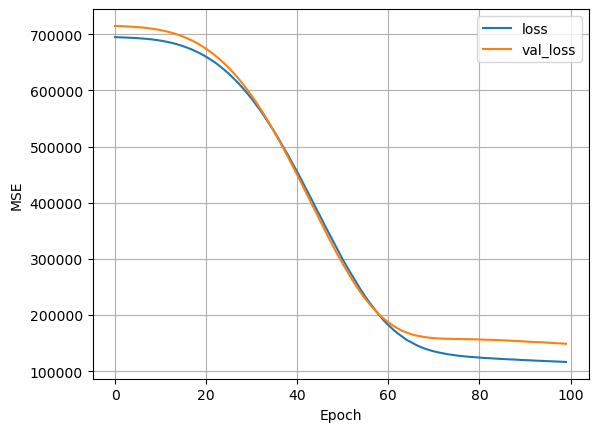

In [ ]:
plot_loss(history)

In [ ]:
# calculating mse for both linear reg and nn
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [ ]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [ ]:
MSE(y_pred_lr, y_test_all)

69948.66223957019

In [ ]:
MSE(y_pred_nn, y_test_all)

108753.14916416546

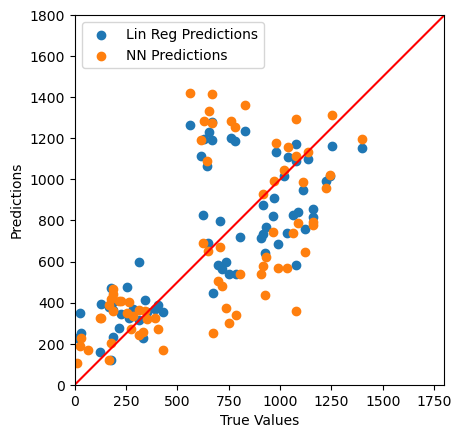

In [ ]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Predictions")
plt.scatter(y_test_all, y_pred_nn, label="NN Predictions")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")